## Trial Assignment: LGU (BGC, Taguig) Traffic

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns; sns.set_style('darkgrid')

### Implementation

#### Data

In [2]:
# Load data--
jams = pd.read_json('jams-processed.json')
alerts = pd.read_json('alerts-processed.json')

# Create `time` feature--
jams['time'] = np.where(jams['speed'] != 0, jams['length'] / jams['speed'], np.nan)
jams.head()

delay      pubMillis                                               line  \
0     99  1499556154925  [{'x': 121.049383, 'y': 14.550538}, {'x': 121....   
1     98  1499556154925  [{'x': 121.049383, 'y': 14.550538}, {'x': 121....   
2     97  1499556154925  [{'x': 121.049383, 'y': 14.550538}, {'x': 121....   
3     95  1499556154925  [{'x': 121.049383, 'y': 14.550538}, {'x': 121....   
4     87  1499763636955  [{'x': 121.049383, 'y': 14.550538}, {'x': 121....   

   roadType  level  endNode     speed    city country  street  length  \
0         1      3  9th Ave  1.433333  Taguig      RP  Lane O     200   
1         1      3  9th Ave  1.447222  Taguig      RP  Lane O     200   
2         1      3  9th Ave  1.455556  Taguig      RP  Lane O     200   
3         1      3  9th Ave  1.475000  Taguig      RP  Lane O     200   
4         1      3  9th Ave  1.563889  Taguig      RP  Lane O     200   

  turnType  type        uuid        request_time blockingAlertUuid startNode  \
0     NONE  NONE  1213296112 2017-07-08 23:22:39               NaN       NaN   
1     NONE  NONE  1213296112 2017-07-08 23:24:39               NaN       NaN   
2     NONE  NONE  1213296112 2017-07-08 23:26:40               NaN       NaN   
3     NONE  NONE  1213296112 2017-07-08 23:28:40               NaN       NaN   
4     NONE  NONE  1415492894 2017-07-11 09:12:19               NaN       NaN   

         time  
0  139.534884  
1  138.195777  
2  137.404580  
3  135.593220  
4  127.886323

#### Functions

In [3]:
def profile_streets(jams):    
    """
    Returns Pandas DataFrame containing information on streets from
    `jams`.
    """
    # NaN check--
    jams['street'] = jams['street'].fillna('Unknown')

    # LENGTH MAXES:
    street_lst = jams.street.unique().tolist()

    streets = {}
    for s in street_lst:
        # Coordinates--
        max_len = jams[jams.street == s].length.max()
        
        # Empty check for list--
        max_len_coords_list = jams[jams.length == max_len].line.tolist()
        max_len_coords = max_len_coords_list[0] if max_len_coords_list else None
        
        # Average speed--
        avg_speed = jams.groupby('street').speed.mean().get(s, np.nan)
        
        # Average time--
        avg_time = jams.groupby('street').time.mean().get(s, np.nan)
        
        # Nodes--
        nodes = jams[jams.street == s].endNode.unique().tolist()
        num_nodes = len(nodes)

        streets[s] = [avg_speed, avg_time, max_len_coords, nodes, num_nodes]
        
    df = pd.DataFrame(streets).T.reset_index()
    df.columns = ['Street', 'AvgSpeed', 'AvgTime', 'Coords', 'Nodes', 'NumNodes']
    return df

df = profile_streets(jams)
df


Street  AvgSpeed     AvgTime  \
0           Lane O  1.717002  181.125376   
1           Lane P  1.374461  201.544729   
2          9th Ave   1.25171   296.27308   
3             28th  1.604494   183.26193   
4          7th Ave  1.183945  230.144839   
..             ...       ...         ...   
73       Las Maria  1.211111  214.678899   
74  Cadena de Amor  2.337407  188.905052   
75         Amapola  2.014422  149.239844   
76    Bougainvilla  1.417914  198.328456   
77           Camia       1.2  220.095528   

                                               Coords  \
0   [{'x': 121.049383, 'y': 14.550538}, {'x': 121....   
1   [{'x': 121.053287, 'y': 14.550435}, {'x': 121....   
2   [{'x': 121.050453, 'y': 14.547906}, {'x': 121....   
3   [{'x': 121.050959, 'y': 14.549419}, {'x': 121....   
4   [{'x': 121.05041, 'y': 14.553588}, {'x': 121.0...   
..                                                ...   
73  [{'x': 121.053316, 'y': 14.552663}, {'x': 121....   
74  [{'x': 121.060231, 'y': 14.55005}, {'x': 121.0...   
75  [{'x': 121.060346, 'y': 14.552713}, {'x': 121....   
76  [{'x': 121.059516, 'y': 14.548129}, {'x': 121....   
77  [{'x': 121.049355, 'y': 14.552287}, {'x': 121....   

                                                Nodes NumNodes  
0                                 [9th Ave, 11th Ave]        2  
1                                  [7th Ave, 9th Ave]        2  
2   [30th, 34th, Lane O, Lane S, 32nd, Lane P, Lan...       19  
3   [5th Ave, 7th Ave, 9th Ave, 11th Ave, nan, 4th...        8  
4   [30th, 28th, 26th, Lane O, 32nd, McKinley Park...       12  
..                                                ...      ...  
73                                       [Sampaguita]        1  
74  [Las Maria, Ilang-Ilang, Rosas, Tarhata, Miras...       11  
75                                   [Cadena de Amor]        1  
76                       [Sampaguita, Cadena de Amor]        2  
77                                   [Cadena de Amor]        1  

[78 rows x 6 columns]

In [8]:
import folium

def map_traffic(jams, night=False):
    """
    Map traffic from `jams`.
    """
    # Create frozensets--
    jams['line_set'] = [frozenset(tuple(d.items()) for d in line) for line in jams['line']]

    # Group by unique line--
    line_profile = jams.groupby('line_set').agg({
        'delay': 'mean',
        'speed': 'mean',
        'length': 'mean',
        'line': 'first'  
    }).reset_index()

    # Folium map--
    map_center = [line_profile['line'][0][0]['y'], line_profile['line'][0][0]['x']]
    m = folium.Map(location=map_center, zoom_start=15, tiles='cartodbpositron')
    if night:
        m = folium.Map(location=map_center, zoom_start=15, tiles='cartodbdark_matter')

    # Plot each line--
    for _, row in line_profile.iterrows():
        line_coords = [(point['y'], point['x']) for point in row['line']]
        
        # Adjust line weight--
        weight = 1 + 10 * (row['delay'] / jams['delay'].max()) 
        opacity = 0.3 
        
        folium.PolyLine(line_coords, color='orange', weight=weight, opacity=opacity).add_to(m)

    display(m)

    return line_profile

r = map_traffic(jams)
r


line_set        delay  \
0     (((x, 121.049383), (y, 14.550538)), ((x, 121.0...   126.904459   
1     (((x, 121.053222), (y, 14.543451)), ((x, 121.0...   383.000000   
2     (((x, 121.058421), (y, 14.550314)), ((x, 121.0...  1298.000000   
3     (((x, 121.058421), (y, 14.550314)), ((x, 121.0...  1308.363636   
4     (((x, 121.058421), (y, 14.550314)), ((x, 121.0...  1261.000000   
...                                                 ...          ...   
1200  (((x, 121.046888), (y, 14.55473)), ((x, 121.04...   146.000000   
1201  (((x, 121.046888), (y, 14.55473)), ((x, 121.04...   193.481013   
1202  (((x, 121.052393), (y, 14.547829)), ((x, 121.0...    73.800000   
1203  (((x, 121.051904), (y, 14.546163)), ((x, 121.0...   204.219512   
1204  (((x, 121.053925), (y, 14.560982)), ((x, 121.0...   620.194245   

         speed  length                                               line  
0     1.326539   200.0  [{'x': 121.049383, 'y': 14.550538}, {'x': 121....  
1     2.883333  1479.0  [{'x': 121.057481, 'y': 14.549869}, {'x': 121....  
2     1.512500  2259.0  [{'x': 121.059198, 'y': 14.551205}, {'x': 121....  
3     1.546970  2331.0  [{'x': 121.059198, 'y': 14.551205}, {'x': 121....  
4     1.822222  2676.0  [{'x': 121.059198, 'y': 14.551205}, {'x': 121....  
...        ...     ...                                                ...  
1200  1.944444   401.0  [{'x': 121.046888, 'y': 14.55473}, {'x': 121.0...  
1201  1.882208   555.0  [{'x': 121.04554, 'y': 14.555185}, {'x': 121.0...  
1202  1.508333   198.0  [{'x': 121.052519, 'y': 14.548202}, {'x': 121....  
1203  1.026152   308.0  [{'x': 121.052519, 'y': 14.548202}, {'x': 121....  
1204  0.473621   333.0  [{'x': 121.053343, 'y': 14.55922}, {'x': 121.0...  

[1205 rows x 5 columns]

In [10]:
def map_by_time(jams, start_time, end_time, night=False):
    """
    Divides data from `jams` into hourly bins.
    """
    import pandas as pd

    jams['request_time'] = pd.to_datetime(jams['request_time'])  # Ensure the column is in datetime format

    # Filter entries--
    if start_time < end_time:
        filtered_df = jams[(jams['request_time'].dt.hour >= start_time) & (jams['request_time'].dt.hour < end_time)]
    else:
        filtered_df = jams[((jams['request_time'].dt.hour >= start_time) | (jams['request_time'].dt.hour < end_time))]

    # Night check--
    if night:
        return map_traffic(filtered_df, night=True)
    else:
        return map_traffic(filtered_df)

map_by_time(jams, 6, 18, night=True)

/var/folders/cb/fzpt3g2x1ms14zbdt1brmjw80000gn/T/ipykernel_56438/158773710.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jams['line_set'] = [frozenset(tuple(d.items()) for d in line) for line in jams['line']]


line_set        delay  \
0     (((x, 121.049383), (y, 14.550538)), ((x, 121.0...   113.682927   
1     (((x, 121.052775), (y, 14.557546)), ((x, 121.0...  1272.811321   
2     (((x, 121.044921), (y, 14.554441)), ((x, 121.0...    95.250000   
3     (((x, 121.044921), (y, 14.554441)), ((x, 121.0...   112.444444   
4     (((x, 121.044036), (y, 14.554724)), ((x, 121.0...    89.000000   
...                                                 ...          ...   
1007  (((x, 121.046862), (y, 14.542241)), ((x, 121.0...   381.500000   
1008  (((x, 121.046862), (y, 14.542241)), ((x, 121.0...   392.000000   
1009  (((x, 121.046888), (y, 14.55473)), ((x, 121.04...   203.818182   
1010  (((x, 121.04629), (y, 14.547322)), ((x, 121.04...   320.255924   
1011  (((x, 121.053925), (y, 14.560982)), ((x, 121.0...   634.273585   

         speed  length                                               line  
0     1.361382   200.0  [{'x': 121.049383, 'y': 14.550538}, {'x': 121....  
1     0.613968   709.0  [{'x': 121.05226, 'y': 14.555989}, {'x': 121.0...  
2     1.187500   171.0  [{'x': 121.044593, 'y': 14.554548}, {'x': 121....  
3     1.371914   234.0  [{'x': 121.044036, 'y': 14.554724}, {'x': 121....  
4     1.811364   291.0  [{'x': 121.043535, 'y': 14.554891}, {'x': 121....  
...        ...     ...                                                ...  
1007  1.836111  1280.0  [{'x': 121.048072, 'y': 14.55248}, {'x': 121.0...  
1008  2.006944  1482.0  [{'x': 121.047163, 'y': 14.54159}, {'x': 121.0...  
1009  1.921212   555.0  [{'x': 121.04554, 'y': 14.555185}, {'x': 121.0...  
1010  1.864363   976.0  [{'x': 121.045804, 'y': 14.545838}, {'x': 121....  
1011  0.472065   333.0  [{'x': 121.053343, 'y': 14.55922}, {'x': 121.0...  

[1012 rows x 5 columns]

In [12]:
def map_multi_pois(place, coords, key, values, colors, zoom_start):
    """
    Map multiple points-of-interest from OSMNX.
    """
    # LIBRARIES:
    import osmnx as ox 
    import folium 
    import pandas as pd
    
    # INITIALIZATION:
    m = folium.Map(coords, zoom_start=zoom_start, tiles='cartodbpositron')
    place = place
    data_frames = []

    for i in range(len(values)):
        data = {}
        tags = {f'{key}':f'{values[i]}'}

        # GEODATAFRAME:
        geom = ox.geometries_from_place(place, tags=tags)
        geom_points = geom[geom.geom_type == 'Point']
        geom_polys = geom[geom.geom_type == 'Polygon']
        loc_points = zip(geom_points.geometry.y, geom_points.geometry.x)
        loc_polys = zip(geom_polys.centroid.y, geom_polys.centroid.x)
        # POLYGONS:
        for location in loc_polys:
            folium.CircleMarker(location=location, fill=True, radius=3, 
                                color=colors[i], fill_color='#31186cc'
                               ,alpha=0.2).add_to(m)
            data[location[0]] = location[1]
        
        # POINTS:
        for location in loc_points:
            folium.CircleMarker(location=location, fill=True,
                       radius=3, color=colors[i], fill_color='#31186cc',
                               alpha=0.2).add_to(m)
            data[location[0]] = location[1]

        # PANDAS DATAFRAME:
        df = pd.DataFrame(data, index=['lon']).T.reset_index()
        df.columns = ['lat', 'lon']
        data_frames.append(df)
 
    return m, data_frames

In [14]:
# INPUTS:
taguig_coords = [14.513083326083665, 121.05545080171883]
key = 'amenity'
values = ['restaurant', ' cafe', 'fast_food']
colors = ['dodgerblue', 'orange', 'lime']
place = 'Fort Bonifacio, Philippines' 
coords = taguig_coords
zoom_start = 13
m, data_frames = map_multi_pois(place, coords, key, values, colors, zoom_start)
m

/var/folders/cb/fzpt3g2x1ms14zbdt1brmjw80000gn/T/ipykernel_56438/2390030300.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  loc_polys = zip(geom_polys.centroid.y, geom_polys.centroid.x)
/var/folders/cb/fzpt3g2x1ms14zbdt1brmjw80000gn/T/ipykernel_56438/2390030300.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  loc_polys = zip(geom_polys.centroid.y, geom_polys.centroid.x)
/Users/filgarcianoiii/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_com

In [27]:
def semihourly_factor(jams, factor, street):
    """
    Determine average factor (delay, speed) per hour.
    """
    def delay_per_street_and_time(jams, start_time, end_time, time_window_minutes):
        import pandas as pd
        
        jams = jams.copy()

        # Datetime--
        jams['request_time'] = pd.to_datetime(jams['request_time'])

        # Calculate bins--
        num_bins = int((end_time - start_time) * 60 / time_window_minutes)

        # New col as time--
        jams['time_window'] = pd.cut(jams['request_time'].dt.hour * 60 + jams['request_time'].dt.minute,
                                     bins=range(start_time * 60, (end_time + 1) * 60, time_window_minutes),
                                     right=False, labels=False)
        if end_time < start_time:
            jams.loc[jams['request_time'].dt.hour < end_time, 'time_window'] += (24 * 60 // time_window_minutes)

        jams['time_window'] = jams.time_window * time_window_minutes
        result_df = jams.groupby(['line_set', 'time_window']).agg({
            'delay': 'mean',
            'length': 'mean',
            'speed': 'mean',
        }).reset_index()

        return result_df

    result_df = delay_per_street_and_time(jams[jams.street == street], 0, 2359, 60)

    result_df['time_window'] = result_df['time_window'].fillna(0)

    mean_delay_per_time_window = result_df.groupby('time_window')[factor].mean()
    return mean_delay_per_time_window

In [28]:
len(semihourly_factor(jams, factor='delay', street='Lane O').keys())

20

In [29]:
bgc_streets = ['Lane O', 'Lane P', '9th Ave', '28th', '7th Ave', '30th', '31st',
               'Lane D', 'Lane Q', '11th Ave', '26th', '32nd', '5th Ave',
               'Federacion Dr', 'Justicia Dr', 'Lane R', '25th', '4th Ave',
               'McKinley Parkway', '6th Ave', '8th Ave', '24th', '34th',
               '3rd Ave', 'Rizal Dr', 'SM Aura/C5 S', '38th', 'De Jesus Oval',
               'Unknown', 'Market Market Service Road', 'SM Aura Service Rd',
               '11: C. P. Garcia S Entry', '23rd', 'Forbes Town Rd', '11th Dr',
               '21st Dr', '191: 32nd St Service Rd',
               '20th Dr', 'Old Lawton', '2nd Ave',
               'University Pkwy', '26th / Target Exit', '1st Ave',
               '191: Ft Bonifacio - Gil Puyat Flyover',
               '191: Buendia / Gil Puyat W Flyover', '36th', '32nd Exit / BGC',
               '26th / Target']
tag_streets = bgc_streets

factors = []
for street in tag_streets:
    factor_series = semihourly_factor(jams, factor='delay', street=street).values
    factors.append(factor_series)
    
street_factors = pd.DataFrame(factors).T
street_factors.columns = tag_streets
street_factors = street_factors.fillna(0)
street_factors.index = semihourly_factor(jams, factor='delay', street='11th Ave').keys()
street_factors

Lane O      Lane P     9th Ave        28th     7th Ave  \
time_window                                                               
0             96.940000   73.562500  171.452457  115.940476  115.393254   
60            93.783550  341.000000  165.430992   87.830688  119.000151   
120           91.972222   95.166667  132.567773   72.722222   91.261074   
180          130.238095  117.869048  123.288038   89.066667   74.166667   
240          167.591071  188.250000  116.061905   84.333333   86.005556   
300          167.155714  171.756410  138.136106   75.833333   88.100000   
360          156.168571  143.187500  126.788529   90.472863   95.373954   
420          242.221429  107.428571  199.055061   80.650718  188.269697   
480          114.175000  193.851190  174.040440  102.948148  141.867857   
540          114.517921  129.708333  202.159323  110.365385  136.896678   
600          122.974524  101.083333  271.359129   99.085000  156.915357   
660          117.465936  138.291667  351.129749  109.067517  159.676953   
720          103.607143  142.375000  201.509084   81.168889  120.710640   
780          118.446581   92.666667  106.619048   69.349351  101.834656   
840          120.000000  170.733333   91.977273   75.466667   78.888889   
900           87.800000  109.000000   87.822222   83.500000   97.375000   
960           97.000000  109.500000   95.000000   96.875000   98.875000   
1020          99.000000   84.000000   80.711111   90.887500  137.666667   
1080         155.500000  142.500000   97.365079   94.112500   83.750000   
1140         152.910714   71.000000   92.447024  106.733333   87.166667   
1200           0.000000  111.000000  134.995536   80.569048   66.000000   
1260           0.000000    0.000000  122.528770   84.750000   86.750000   
1320           0.000000    0.000000   79.250000   66.200000    0.000000   
1380           0.000000    0.000000  126.083333   88.812500    0.000000   

                   30th        31st      Lane D      Lane Q    11th Ave  ...  \
time_window                                                              ...   
0             96.035645  168.000000  234.500000  105.444444   93.560577  ...   
60           154.791670  119.750000  197.500000  146.880000   86.525253  ...   
120          115.025763  142.500000  162.666667   90.000000  131.656446  ...   
180           93.061786   90.833333    0.000000  148.400000  197.842093  ...   
240           85.727002   69.250000    0.000000  101.392857  134.924268  ...   
300           97.691040   76.000000    0.000000  112.666667  121.483599  ...   
360          111.470988   73.000000    0.000000  138.351351  155.941808  ...   
420          125.478699   86.000000    0.000000  144.555556  168.566721  ...   
480           96.605538   83.300000    0.000000  103.562500  173.641895  ...   
540          114.762939  115.097588    0.000000  155.163265  217.240716  ...   
600          131.895800  157.934959    0.000000  156.084746  445.415494  ...   
660          159.899510   95.825000    0.000000  169.344828  784.193795  ...   
720          122.334679   71.000000    0.000000  123.111111  474.540978  ...   
780          102.070852   84.357143    0.000000  123.555556  134.400786  ...   
840           91.233333   82.500000    0.000000   96.615385  109.284314  ...   
900           85.045455  118.291667    0.000000   97.000000  129.271825  ...   
960           86.804762   95.500000    0.000000  306.400000  191.396011  ...   
1020          75.253846  117.250000    0.000000   82.000000  201.208333  ...   
1080          91.593810    0.000000    0.000000   93.100000   86.200000  ...   
1140          84.583333    0.000000    0.000000    0.000000   67.875000  ...   
1200          83.937500    0.000000    0.000000    0.000000  113.000000  ...   
1260          83.333333    0.000000    0.000000    0.000000   78.722222  ...   
1320          85.250000    0.000000    0.000000    0.000000   90.611111  ...   
1380          90.416667    0.000000    0.000000    0.000000   84.6

/Users/filgarcianoiii/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/filgarcianoiii/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/filgarcianoiii/anaconda3/lib/python3.9/site-packages/seaborn/palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ge

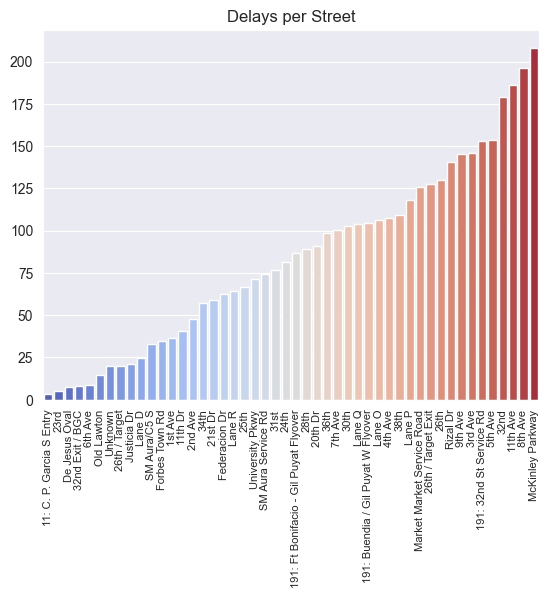

In [30]:
sns.barplot(
    x=np.mean(street_factors).sort_values(ascending=True).keys(), 
    y=np.mean(street_factors).sort_values(ascending=True).values,
    palette='coolwarm'
);
plt.xticks(rotation=90, size=8);
plt.title('Delays per Street');

In [31]:
# LENGTH VIA STREET:
# pd.DataFrame({
#     'Street':jams.groupby('street').length.mean().sort_values(ascending=False).head(10).keys(), 
#     'Length':jams.groupby('street').length.mean().sort_values(ascending=False).head(10).values
# }).to_csv('length_street.csv', index=False)

In [32]:
# DELAY VIA STREET:
# pd.DataFrame({
#     'Street':jams.groupby('street').delay.mean().keys(),
#     'Delay':jams.groupby('street').delay.mean().values
# }).sort_values(by='Delay', ascending=False).head(10).to_csv('delay_street.csv', index=False)

In [33]:
# SPEED, HOUR, LEVEL:
# qr = jams.copy()
# qr['hour'] = qr['request_time'].dt.hour
# qs = pd.DataFrame({
#     'Speed':qr.groupby('hour').speed.mean()
# })
# qs['Level4Speed'] = jams[jams.level == 4].groupby('hour').speed.mean()
# qs['Level3Speed'] = jams[jams.level == 3].groupby('hour').speed.mean()
# qs.to_csv('speed_hour_level.csv', index=True)

In [34]:
# qx = jams[jams.street == '32nd'].copy()
# qx['hour'] = qx['request_time'].dt.hour
# qx = pd.DataFrame({
#     'Delay':qx.groupby('hour').delay.mean(),
#     'Speed':qx.groupby('hour').speed.mean(),    
# })
# qx.to_csv('delay_speed_32nd.csv', index=True)

In [36]:
import folium

accidents_df = accidents_df[accidents_df.type == 'ACCIDENT']
accidents_df['hour'] = accidents_df['request_time'].dt.hour
m = folium.Map(location=[accidents_df['location'][318]['y'], accidents_df['location'][318]['x']], zoom_start=15, tiles='cartodbpositron')

color_major = 'blue'
color_minor = 'green'

for index, row in accidents_df.iterrows():
    lat, lon = row['location']['y'], row['location']['x']
    color = color_major if 'MAJOR' in row['subtype'] else color_minor
    folium.CircleMarker(location=[lat, lon], radius=3, hue='hour', fill_opacity=0, fill_color='white',
                        popup=row['hour']).add_to(m)
m


/Users/filgarcianoiii/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


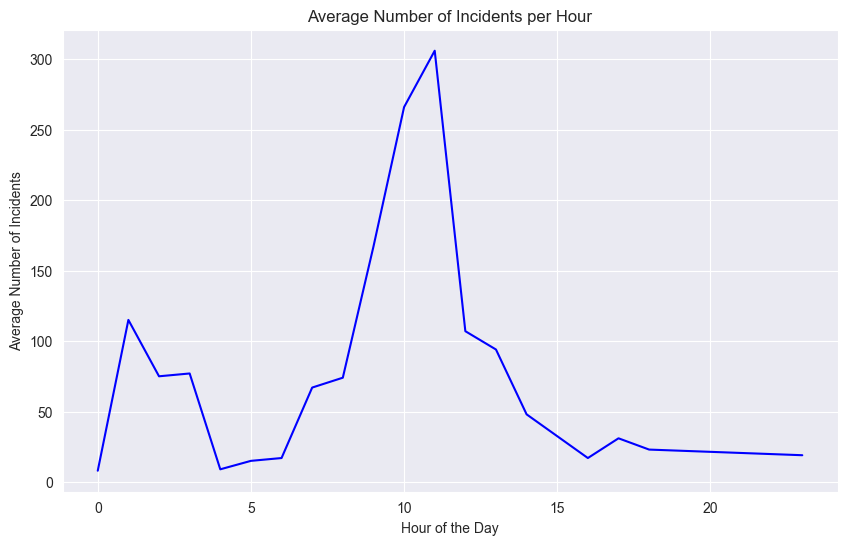

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'request_time' is in datetime format
accidents_df['hour'] = accidents_df['request_time'].dt.hour

# Group by hour and calculate the average number of incidents
average_incidents_per_hour = accidents_df.groupby('hour').size()

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(average_incidents_per_hour, linestyle='-', color='b')
plt.title('Average Number of Incidents per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Incidents')
plt.grid(True)
plt.show()
